In [1]:
"""
RNA CLUSTER ANALYSIS PIPELINE FOR SUBMISSION
Created: 2025-06-11
Author: Qin Zhang

DESCRIPTION:
Configures system parameters for cluster analysis of:
- 3xG4C2, 5xG4C2, and 8xG4C2 RNA systems
- Salt concentrations ranging from neutral to 696mM NaCl and 417mMMgCl2
- Cluster detection using periodic boundary-corrected KDTree

KEY PARAMETERS:
- cutoff_distances: List of interaction cutoffs (Å) for cluster definition
- stride: Trajectory sampling frequency (frames)
- bead_sizes: Martini bead radii for effective distance calculation

DATA PATHS:
Raw data stored in Zenodo-archived directories (DOI: 10.5281/zenodo.15608685)
"""
# %% Cell 1: Configure parameters and dependencies
# Import core scientific computing libraries
import numpy as np
import MDAnalysis as mda  # For trajectory parsing
from scipy.spatial import cKDTree  # For fast spatial queries
from tqdm import tqdm  # For progress bars
import os
import matplotlib.pyplot as plt
import json

# Define simulation directory paths for 3xG4C2 system
conditions_3x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_5x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_8x = {
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/C_8xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/"
}
# Chain definitions for different RNA systems (atom index ranges)
chains_3x = { 
    "ch1": 'index 0 to 215',
    "ch2": 'index 216 to 431',
    "ch3": 'index 432 to 647',
    "ch4": 'index 648 to 863',
    "ch5": 'index 864 to 1079',
    "ch6": 'index 1080 to 1295',
    "ch7": 'index 1296 to 1511',
    "ch8": 'index 1512 to 1727',
    "ch9": 'index 1728 to 1943',
    "ch10": 'index 1944 to 2159',
    "ch11": 'index 2160 to 2375',
    "ch12": 'index 2376 to 2591'
}
chains_5x = {
    "ch1": 'index 0 to 359',
    "ch2": 'index 360 to 719',
    "ch3": 'index 720 to 1079',
    "ch4": 'index 1080 to 1439',
    "ch5": 'index 1440 to 1799',
    "ch6": 'index 1800 to 2159',
    "ch7": 'index 2160 to 2519',
    "ch8": 'index 2520 to 2879',
    "ch9": 'index 2880 to 3239',
    "ch10": 'index 3240 to 3599',
    "ch11": 'index 3600 to 3959',
    "ch12": 'index 3960 to 4319'
}
chains_8x = {
    "ch1": 'index 0 to 575',
    "ch2": 'index 576 to 1151',
    "ch3": 'index 1152 to 1727',
    "ch4": 'index 1728 to 2303',
    "ch5": 'index 2304 to 2879',
    "ch6": 'index 2880 to 3455',
    "ch7": 'index 3456 to 4031',
    "ch8": 'index 4032 to 4607',
    "ch9": 'index 4608 to 5183',
    "ch10": 'index 5184 to 5759',
    "ch11": 'index 5760 to 6335',
    "ch12": 'index 6336 to 6911'
}

# Martini bead radii (Å) for effective distance calculation
bead_sizes = {
    # Bead types from Martini 3.0 RNA forcefield. We don't take into account the beads size here
    "BB": 0,  "BB1": 0,"BB3": 0,"BB2": 0, "BVS": 0,"SC1": 0,"SC2": 0,"SC3": 0,"SC4": 0,"SC5": 0,"SC6": 0,"SC7": 0
}
# Critical parameter: Cluster detection cutoff
cutoff_distances = [13.5]

# Sampling rate: Process every 25th frame for efficiency
stride = 25

In [2]:
# %% Cell 2: Core function definitions
def get_bead_size(bead_name):
    """
    Retrieve Martini bead radius by name
    
    Parameters:
        bead_name (str): Bead identifier (e.g., 'BB', 'SC1')
    
    Returns:
        float: Bead radius in Angstroms (0 if undefined)
    """
    for key in bead_sizes:
        if key in bead_name:
            return bead_sizes[key]
    return 0.0  # Default value

def detect_clusters(positions, bead_names, cutoff):
    """
    Detect RNA clusters using union-find algorithm with PBC correction
    
    Algorithm:
    1. Build KDTree for fast neighbor search
    2. Compute effective distance: d_eff = d - (R_i + R_j)
    3. Establish adjacency matrix (cutoff: 13.5Å)
    4. Apply union-find to identify connected components
    
    Parameters:
        positions (list): Per-RNA bead coordinates
        bead_names (list): Corresponding bead identifiers
        cutoff (float): Effective interaction cutoff (Å)
    
    Returns:
        int: Number of distinct clusters
    """
    n_rna = len(positions)
    adjacency_matrix = np.zeros((n_rna, n_rna), dtype=bool)
    
    # Step 1: Establish adjacency relationships
    for i in range(n_rna):
        for j in range(i+1, n_rna):
            # Use cKDTree for fast nearest bead pair search
            tree_i = cKDTree(positions[i])
            dists, indices = tree_i.query(positions[j], k=1)
            
            # Calculate effective distance (subtract sum of bead radii)
            bead_size_i = get_bead_size(bead_names[i][indices])
            bead_size_j = get_bead_size(bead_names[j][np.arange(len(positions[j]))])
            effective_dists = dists - (bead_size_i + bead_size_j) / 2
            
            # Key improvement: Take minimum effective distance across all bead pairs
            if np.min(effective_dists) < cutoff:
                adjacency_matrix[i, j] = True
                adjacency_matrix[j, i] = True
                
    # Step 2: Union-find algorithm to detect connected components
    parent = list(range(n_rna))
    
    def find(u):
        """Path-compressed root node finder"""
        while parent[u] != u:
            parent[u] = parent[parent[u]]  # Path compression optimization
            u = parent[u]
        return u
    
    # Merge connected components
    for i in range(n_rna):
        for j in range(i+1, n_rna):
            if adjacency_matrix[i, j]:
                root_i = find(i)
                root_j = find(j)
                if root_i != root_j:
                    parent[root_j] = root_i
                    
    # Count independent clusters
    clusters = set()
    for k in range(n_rna):
        clusters.add(find(k))
    
    return len(clusters)

def analyze_replica(gro_file, xtc_file, chains, cutoffs, stride):
    """
    Analyze single simulation replica across multiple cutoffs
    
    Workflow:
    1. Load topology/trajectory with MDAnalysis
    2. Extract RNA chain coordinates
    3. Process frames with given stride
    4. Apply cluster detection per frame
    
    Returns:
        dict: {cutoff: average cluster count}
    """
    u = mda.Universe(gro_file, xtc_file)
    
    # Preload all RNA selectors and bead names
    selections = [u.select_atoms(chain) for chain in chains.values()]
    bead_names = [ag.names for ag in selections]
    
    # Initialize result storage
    cutoff_results = {cutoff: [] for cutoff in cutoffs}
    
    # Analyze frame by frame
    for ts in tqdm(u.trajectory[::stride], desc="Analyzing frames"):
        # Key improvement: Handle periodic boundary conditions
        u.atoms.pack_into_box()
        
        # Get coordinates for all RNAs in current frame
        current_positions = [ag.positions.copy() for ag in selections]
        
        # Calculate for each cutoff separately
        for cutoff in cutoffs:
            n_clusters = detect_clusters(current_positions, bead_names, cutoff)
            cutoff_results[cutoff].append(n_clusters)
    
    # Calculate average for each cutoff
    return {k: np.mean(v) for k, v in cutoff_results.items()}
    
def analyze_conditions(conditions, chains, cutoffs, stride, condition_type):
    """
    Master analysis function for RNA systems
    
    Processes 4 replicas per condition:
    1. Validate file existence
    2. Parallelize replica analysis
    3. Aggregate results by salt concentration
    
    Returns:
        dict: results[condition][cutoff] = [replica_means]
    """
    results = {}
    for cond_name, base_path in conditions.items():
        print(f"\nAnalyzing condition: {condition_type} - {cond_name}")
        replica_results = []
        
        # Process 4 replicas
        for replica in ["C1", "C2", "C3", "C4"]:
            gro_path = os.path.join(base_path, replica, "RNA.gro")
            xtc_path = os.path.join(base_path, replica, "RNA_clusterRNA.xtc")
            
            if not os.path.exists(gro_path) or not os.path.exists(xtc_path):
                print(f"Warning: Missing files {replica}")
                continue
                
            # Analyze single replica
            rep_result = analyze_replica(gro_path, xtc_path, chains, cutoffs, stride)
            replica_results.append(rep_result)
        
        # Merge data from all replicas by cutoff distance
        if replica_results:
            cond_results = {}
            for cutoff in cutoffs:
                # Extract data from all replicas with current cutoff
                cond_results[str(cutoff)] = [res[cutoff] for res in replica_results]
            results[cond_name] = cond_results
            
    return results

In [3]:
# %% Cell 3: Data analysis and save results
def save_results(results, filename):
    """
    Save analysis results as JSON for reproducibility
    
    Output format:
    {
      "neutral": {"13.5": [2.1, 1.9, 2.0, 2.1]},
      "17mMNaCl": {"13.5": [3.4, 3.2, 3.5, 3.3]},
      ...
    }
    """
    """Save analysis results to JSON file"""
    with open(filename, "w") as f:
        json.dump(results, f, indent=2)

# Run analysis (only execute on first run)
if not os.path.exists("results_3x.json"):
    results_3x = analyze_conditions(conditions_3x, chains_3x, cutoff_distances, stride, "3xG4C2")
    save_results(results_3x, "results_3x.json")
else:
    print("Found existing 3xG4C2 results, skipping analysis")

if not os.path.exists("results_5x.json"):
    results_5x = analyze_conditions(conditions_5x, chains_5x, cutoff_distances, stride, "5xG4C2")
    save_results(results_5x, "results_5x.json")
else:
    print("Found existing 5xG4C2 results, skipping analysis")

if not os.path.exists("results_8x.json"):
    results_8x = analyze_conditions(conditions_8x, chains_8x, cutoff_distances, stride, "8xG4C2")
    save_results(results_8x, "results_8x.json")
else:
    print("Found existing 8xG4C2 results, skipping analysis")


Analyzing condition: 3xG4C2 - neutral


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:05<00:00, 69.52it/s]



Analyzing condition: 3xG4C2 - 17mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:06<00:00, 65.63it/s]



Analyzing condition: 3xG4C2 - 35mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:05<00:00, 69.03it/s]



Analyzing condition: 3xG4C2 - 70mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:06<00:00, 66.42it/s]



Analyzing condition: 3xG4C2 - 139mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:06<00:00, 64.89it/s]



Analyzing condition: 3xG4C2 - 278mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:06<00:00, 66.14it/s]



Analyzing condition: 3xG4C2 - 487mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:06<00:00, 64.17it/s]



Analyzing condition: 3xG4C2 - 696mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:06<00:00, 63.31it/s]



Analyzing condition: 5xG4C2 - neutral


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:08<00:00, 48.42it/s]



Analyzing condition: 5xG4C2 - 17mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:08<00:00, 44.66it/s]



Analyzing condition: 5xG4C2 - 35mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:08<00:00, 45.32it/s]



Analyzing condition: 5xG4C2 - 70mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:08<00:00, 45.01it/s]



Analyzing condition: 5xG4C2 - 139mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:09<00:00, 42.21it/s]



Analyzing condition: 5xG4C2 - 278mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:09<00:00, 41.30it/s]



Analyzing condition: 5xG4C2 - 487mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:09<00:00, 40.69it/s]



Analyzing condition: 5xG4C2 - 696mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:09<00:00, 40.77it/s]
/opt/anaconda3/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "



Analyzing condition: 8xG4C2 - 487mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:17<00:00, 23.15it/s]


In [7]:
# %% Cell 4: Load saved results
import numpy as np
def load_results(filename):
    """Load results from JSON file"""
    with open(filename, "r") as f:
        return json.load(f)

results_3x = load_results("results_3x.json")
results_5x = load_results("results_5x.json")
results_8x = load_results("results_8x.json")

def print_target_sd(results, condition_type, target_conditions, cutoff):
    """
    Report statistical details for target conditions
    
    Calculates:
    - Global mean across replicas
    - Per-replica deviation
    - Standard deviation (n-1 weighted)
    
    Output format:
    🔬 3xG4C2 - Detailed SD calculation
      ├─ Conditions: neutral
      ├─ Replica mean: [1.0, 2.0, 1.0, 1.0]
      ├─ Global mean: 1.25
      └─ SD: 0.50    
        """
    print(f"\n🔬 {condition_type} - Detailed SD calculation")
    for cond_name in target_conditions:
        if cond_name not in results:
            print(f"  ⚠️ {cond_name}: Data does not exist")
            continue
            
        cond_data = results[cond_name].get(str(cutoff), [])
        if len(cond_data) < 2:
            print(f"  ⚠️ {cond_name}: Insufficient valid replicas")
            continue
            
        global_mean = np.mean(cond_data)
        deviations = [x - global_mean for x in cond_data]
        sd = np.sqrt(sum(d**2 for d in deviations) / (len(cond_data)-1))
        
        print(f"  ├─ Conditions: {cond_name}")
        print(f"  ├─ Replica mean: {[round(x,2) for x in cond_data]}")
        print(f"  ├─ Global mean: {global_mean:.2f}")
        print(f"  └─ SD: {sd:.2f}\n")
cutoff = 13.5
print("="*50)
print(f"Verify cutoff distance: {cutoff} Å")
print("="*50)

# 3xG4C2: neutral, 17mMNaCl
print_target_sd(results_3x, "3xG4C2", ["neutral", "17mMNaCl"], cutoff)
# 5xG4C2: neutral, 17mMNaCl
print_target_sd(results_5x, "5xG4C2", ["neutral", "17mMNaCl"], cutoff)
# 8xG4C2: 487mMNaCl
print_target_sd(results_8x, "8xG4C2", ["487mMNaCl"], cutoff)


Verify cutoff distance: 13.5 Å

🔬 3xG4C2 - Detailed SD calculation
  ├─ Conditions: neutral
  ├─ Replica mean: [1.0, 2.0, 1.0, 1.0]
  ├─ Global mean: 1.25
  └─ SD: 0.50

  ├─ Conditions: 17mMNaCl
  ├─ Replica mean: [1.0, 1.14, 1.0, 1.0]
  ├─ Global mean: 1.03
  └─ SD: 0.07


🔬 5xG4C2 - Detailed SD calculation
  ├─ Conditions: neutral
  ├─ Replica mean: [1.0, 1.0, 1.0, 1.0]
  ├─ Global mean: 1.00
  └─ SD: 0.00

  ├─ Conditions: 17mMNaCl
  ├─ Replica mean: [1.0, 1.0, 1.0, 1.0]
  ├─ Global mean: 1.00
  └─ SD: 0.00


🔬 8xG4C2 - Detailed SD calculation
  ├─ Conditions: 487mMNaCl
  ├─ Replica mean: [2.35, 2.22, 2.87, 4.39]
  ├─ Global mean: 2.96
  └─ SD: 0.99




► Condition: 3xG4C2 neutral
   - Global average (Global Mean): 1.25
   - Difference between copies (Deviations): [-0.25  0.75 -0.25 -0.25]
   - Standard deviation (SD): 0.50

► Condition: 3xG4C2 17mMNaCl
   - Global average (Global Mean): 1.03
   - Difference between copies (Deviations): [-0.03  0.1  -0.03 -0.03]
   - Standard deviation (SD): 0.07

► Condition: 3xG4C2 35mMNaCl
   - Global average (Global Mean): 1.00
   - Difference between copies (Deviations): [0. 0. 0. 0.]
   - Standard deviation (SD): 0.00

► Condition: 3xG4C2 70mMNaCl
   - Global average (Global Mean): 1.00
   - Difference between copies (Deviations): [0. 0. 0. 0.]
   - Standard deviation (SD): 0.00

► Condition: 3xG4C2 139mMNaCl
   - Global average (Global Mean): 1.00
   - Difference between copies (Deviations): [0. 0. 0. 0.]
   - Standard deviation (SD): 0.00

► Condition: 3xG4C2 278mMNaCl
   - Global average (Global Mean): 2.02
   - Difference between copies (Deviations): [-0.5   0.82  0.71 -1.02]
   - Standard 

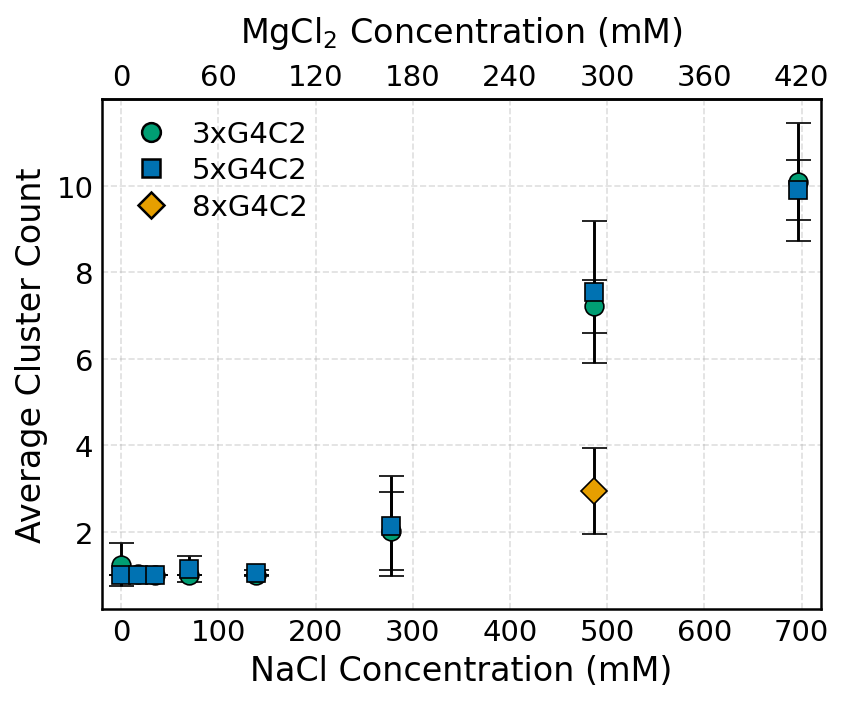

In [10]:
# %%Cell5: Publication-quality figure generation 
%matplotlib inline
import numpy as np
import MDAnalysis as mda
from scipy.spatial import cKDTree
from tqdm import tqdm
import re 
import json
from matplotlib.ticker import MultipleLocator
cutoff_distances = [13.5]
import matplotlib
import matplotlib.pyplot as plt

def plot_combined_results(results_3x, results_5x, results_8x, cutoffs):
    """
    Design specs:
    - 3.33in width (single-column)
    - 300 DPI minimum
    - CMYK-compatible colors
    - Error bars: SD across replicas
    - Dual x-axis: NaCl/MgCl₂ concentrations
    """
    plt.rcParams.update({
        'font.size': 7,                
        'axes.labelsize': 8,            
        'xtick.labelsize': 7,           
        'ytick.labelsize': 7,           
        'legend.fontsize': 7,           
        'figure.figsize': (3.33, 2.5),  
        'axes.linewidth': 0.6,          
        'lines.linewidth': 1.0,         
        'lines.markeredgewidth': 0.6,   
        'grid.linewidth': 0.4,          
        'figure.dpi' : 300,
        'savefig.dpi': 300,             
        'savefig.format': 'png',        
        'pdf.fonttype': 42,             
        'font.family': 'DejaVu Sans',   
        'mathtext.default': 'regular'   
    })
    
    fig, ax = plt.subplots()
    condition_colors = {
        '3xG4C2': '#009E73',  
        '5xG4C2': '#0072B2'  
        # '8xG4C2': '#E69F00' 
    }
    markers = {
        '3xG4C2': 'o',
        '5xG4C2': 's'
        # '8xG4C2': 'D'
    }
    nacl_to_mgcl2 = lambda x: x * (420/700)
    mgcl2_to_nacl = lambda x: x * (700/420)
    salt_concentrations = [0, 17, 35, 70, 139, 278, 487, 696]

    # Force all axis borders to be black
    for spine in ax.spines.values():
        spine.set_color('black')
    for i, cutoff in enumerate(cutoffs):
        data_3x, data_5x, data_8x = [], [], []
        sd_3x, sd_5x, sd_8x = [], [], []
        x_3x, x_5x, x_8x = [], [], []
        def print_sd_details(condition_type, cond_name, vals, conc, cutoff):
            if len(vals) < 2:
                print(f"⚠️ Warning: {condition_type} {cond_name} (cutoff={cutoff}Å) only {len(vals)} replicas，unable to calculate SD")
                return
            global_mean = np.mean(vals)
            deviations = [x - global_mean for x in vals]
            sd = np.std(vals, ddof=1)

            print(f"\n► Condition: {condition_type} {cond_name}")
            print(f"   - Global average (Global Mean): {global_mean:.2f}")
            print(f"   - Difference between copies (Deviations): {np.round(deviations, 2)}")
            print(f"   - Standard deviation (SD): {sd:.2f}")
        # processing 3xG4C2   
        for conc in salt_concentrations:
            cond_3x = next((c for c in results_3x if get_conc(c) == conc), None)
            if cond_3x and str(cutoff) in results_3x[cond_3x]:# Try different interactive backends (ordered by Line2D([0], [0], priority)
                vals = results_3x[cond_3x][str(cutoff)]
                if vals:
                    print_sd_details("3xG4C2", cond_3x, vals, conc, cutoff)
                    x_3x.append(conc)
                    data_3x.append(np.mean(vals))
                    sd_3x.append(np.std(vals, ddof=1))  # SD
        # processing 5xG4C2
        for conc in salt_concentrations:
            cond_5x = next((c for c in results_5x if get_conc(c) == conc), None)
            if cond_5x and str(cutoff) in results_5x[cond_5x]:
                vals = results_5x[cond_5x][str(cutoff)]
                if vals:
                    print_sd_details("5xG4C2", cond_5x, vals, conc, cutoff)
                    x_5x.append(conc)
                    data_5x.append(np.mean(vals))
                    sd_5x.append(np.std(vals, ddof=1))                    
        # processing 8xG4C2
        for conc in salt_concentrations:
            if conc == 487 and "487mMNaCl" in results_8x:
                vals = results_8x["487mMNaCl"].get(str(cutoff), [])
                if vals:
                    print_sd_details("8xG4C2", "487mMNaCl", vals, conc, cutoff)
                    x_8x.append(conc)
                    data_8x.append(np.mean(vals))
                    sd_8x.append(np.std(vals, ddof=1))
        # plotting 3xG4C2
        ax.errorbar(x_3x, data_3x, yerr=sd_3x,
                   fmt='o',  
                   markersize=4.5,
                   capsize=3,
                   capthick=0.7,
                   ecolor='black',
                   elinewidth=0.7,
                   color=condition_colors['3xG4C2'],  
                   markerfacecolor=condition_colors['3xG4C2'],
                   markeredgecolor='k',
                   markeredgewidth=0.4,
                   zorder=3)
        # plotting 5xG4C2 
        ax.errorbar(x_5x, data_5x, yerr=sd_5x,
                   fmt='s',  
                   markersize=4.5,
                   capsize=3,
                   capthick=0.7,
                   ecolor='black',
                   elinewidth=0.7,
                   color=condition_colors['5xG4C2'],
                   markerfacecolor=condition_colors['5xG4C2'],
                   markeredgecolor='k',
                   markeredgewidth=0.4,
                   zorder=3)
        # plotting 8xG4C2 
        # if x_8x:
        #     ax.errorbar(x_8x, data_8x, yerr=sd_8x,
        #                fmt='D',  
        #                markersize=4.5,
        #                capsize=3,
        #                capthick=0.7,
        #                ecolor='black',
        #                elinewidth=0.7,
        #                color=condition_colors['8xG4C2'],
        #                markerfacecolor=condition_colors['8xG4C2'],
        #                markeredgecolor='k',
        #                markeredgewidth=0.4,
        #                zorder=3)
            
    from matplotlib.lines import Line2D
    ax.set_xlabel('NaCl Concentration (mM)', labelpad=2)
    ax.set_ylabel('Average Cluster Count', labelpad=2)    
    ax.set_xlim(-20, 720)
    ax.xaxis.set_major_locator(MultipleLocator(100))
    # ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.tick_params(axis='x', length=0, pad=2)
    ax.tick_params(axis='y', length=0, pad=2)

    ax2 = ax.secondary_xaxis('top', functions=(nacl_to_mgcl2, mgcl2_to_nacl))
    ax2.set_xlabel('MgCl$_2$ Concentration (mM)', labelpad=5)
    ax2.xaxis.set_major_locator(MultipleLocator(60))
    ax2.tick_params(axis='x',  which='both',  length=0, pad=2)

    ax.grid(True, which='major', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.2)

    legend_elements = [
        (
            Line2D([0], [0], 
                  marker='o', 
                  color=condition_colors['3xG4C2'],
                  markerfacecolor=condition_colors['3xG4C2'],
                  markeredgecolor='k',
                  markersize=4.5,
                  linestyle='None'),
        ),
        (
            Line2D([0], [0], 
                  marker='s', 
                  color=condition_colors['5xG4C2'],
                  markerfacecolor=condition_colors['5xG4C2'],
                  markeredgecolor='k',
                  markersize=4.5,
                  linestyle='None'),
        )
        
        # (
        #     Line2D([0], [0], 
        #           marker='D', 
        #           color=condition_colors['8xG4C2'],
        #           markerfacecolor=condition_colors['8xG4C2'],
        #           markeredgecolor='k',
        #           markersize=4.5,
        #           linestyle='None'),
        # )
    ]
    from matplotlib.legend_handler import HandlerTuple
    leg = ax.legend(
        handles=legend_elements,
        labels=['3xG4C2', '5xG4C2', '8xG4C2'],
        handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        frameon=False,
        loc='upper left',
        borderpad=0.2,
        handletextpad=0.4,
        labelspacing=0.3
    )
    plt.subplots_adjust(
        left=0.18,    
        bottom=0.16,
        top=0.84   
    )
    plt.savefig(
        'Figure2b.png',
        dpi=300,
        bbox_inches='tight', format='png',
        pad_inches=0.02
    )
    plt.show()

def get_conc(cond_name):
    if cond_name == "neutral":
        return 0.0
    numbers = re.findall(r'\d+', cond_name)
    return float(numbers[-1]) if numbers else 0.0            

plot_combined_results(results_3x, results_5x, results_8x, cutoff_distances)


Detailed Statistics for Cutoff: 13.5Å
System: 3xG4C2 | Cutoff: 13.5Å
   - Replica values: [7.12 8.01 7.21 6.53]
   - Global mean: 7.22
   - Differences: [-0.10 0.79 -0.00 -0.69]
   - Standard deviation: 0.61
----------------------------------------
System: 5xG4C2 | Cutoff: 13.5Å
   - Replica values: [9.25 6.78 5.65 8.51]
   - Global mean: 7.55
   - Differences: [1.70 -0.77 -1.89 0.96]
   - Standard deviation: 1.63
----------------------------------------
System: 8xG4C2 | Cutoff: 13.5Å
   - Replica values: [2.35 2.22 2.87 4.39]
   - Global mean: 2.96
   - Differences: [-0.60 -0.74 -0.09 1.43]
   - Standard deviation: 0.99
----------------------------------------


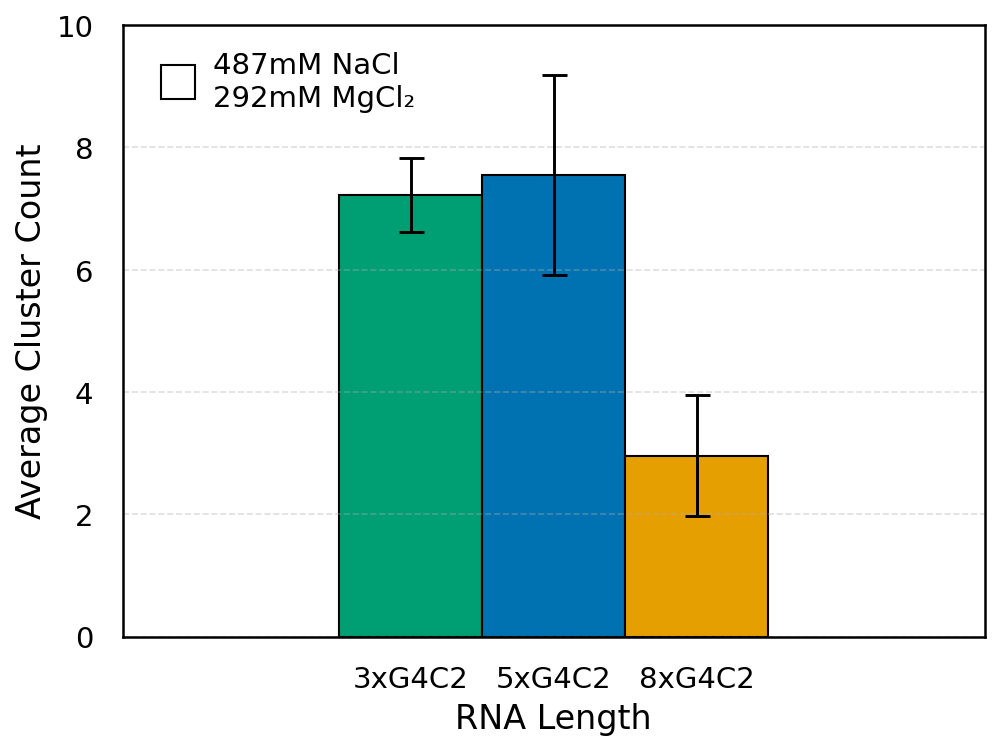

In [11]:
from matplotlib.lines import Line2D
def plot_487mM_bar(results_3x, results_5x, results_8x, cutoffs):
    """
    Includes:
    - Bar plot with SD error bars
    - Statistical annotation
    - Journal-compliant styling
    """
    plt.close('all')  
    # Set styling to match code 2
    plt.rcParams.update({
        'font.size': 7,
        'axes.labelsize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'font.family': 'DejaVu Sans',
        'figure.dpi': 300,
        'figure.figsize': (3.33, 2.5),  # Code 2's dimensions
        'axes.linewidth': 0.6,
        'grid.linestyle': '--',
        'grid.alpha': 0.4,
        'xtick.major.width': 0,
        'ytick.major.width': 0,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.05
    })
    fig, ax = plt.subplots()
    systems = ['3xG4C2', '5xG4C2', '8xG4C2']
    system_colors = ['#009E73', '#0072B2','#E69F00']
    
    # Use only the first cutoff (13.5Å) 
    target_cutoff = str(cutoffs[0])
    bar_means = []
    bar_sds = []
    # Print header for the data section
    print("Detailed Statistics for Cutoff: 13.5Å")
    print("="*40)
    for system in systems:
        if system == '3xG4C2':
            data = results_3x["487mMNaCl"].get(target_cutoff, [])
        elif system == '5xG4C2':
            data = results_5x["487mMNaCl"].get(target_cutoff, [])
        else:
            data = results_8x["487mMNaCl"].get(target_cutoff, [])

        if data:
            # Calculate statistics
            global_mean = np.mean(data)
            sd = np.std(data, ddof=1)
            differences = [round(x - global_mean, 2) for x in data]
            
            bar_means.append(global_mean)
            bar_sds.append(sd)
            # Format data for printing
            data_str = " ".join([f"{x:.2f}" for x in data])
            diff_str = " ".join([f"{x:.2f}" for x in differences])
            # Print system statistics
            print(f"System: {system} | Cutoff: {target_cutoff}Å")
            print(f"   - Replica values: [{data_str}]")
            print(f"   - Global mean: {global_mean:.2f}")
            print(f"   - Differences: [{diff_str}]")
            print(f"   - Standard deviation: {sd:.2f}")
            print("-" * 40)
        else:
            bar_means.append(0)
            bar_sds.append(0)
            print(f"System: {system} | No data available for cutoff {target_cutoff}Å")
            print("-" * 40)
    bar_width = 0.33  
    x_pos = np.arange(len(systems)) * bar_width 
    ax.bar(
        x_pos, bar_means, bar_width,
        yerr=bar_sds, color=system_colors,
        edgecolor='k', linewidth=0.5,
        align='edge', error_kw={'elinewidth': 0.7, 'capsize': 3, 'capthick': 0.7}
    )

    ax.set_xticks(x_pos + bar_width/2) 
    ax.set_xticklabels(systems)
    ax.set_xlabel('RNA Length', labelpad=2)
    ax.set_ylabel('Average Cluster Count', labelpad=2) #Average Cluster Count < 13.5 Å.
    ax.set_xlim(x_pos[0]-0.5, x_pos[-1]+bar_width+0.5) 
    ax.set_ylim(0, 10) 

    legend_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor='w',
                       markeredgecolor='k', markersize=8, markeredgewidth=0.5,
                       label='487mM NaCl\n292mM MgCl₂')]
    ax.legend(handles=legend_elements, loc='upper left', 
             framealpha=0,  # Set transparency to 0
             facecolor='none',  # No fill color
             edgecolor='none',  # No border
             handletextpad=0.2,
             borderaxespad=0.5)

    ax.yaxis.grid(True, linestyle='--', alpha=0.4, linewidth=0.4)
    plt.subplots_adjust(left=0.12, right=0.98, bottom=0.16, top=0.92)
    plt.tight_layout(pad=0.5)
    plt.savefig('Figure2c.png', dpi=300)
    plt.show()
cutoff_distances = [13.5]  
plot_487mM_bar(results_3x, results_5x, results_8x, cutoff_distances)